In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Importing libraries
# TensorFlow libraries
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import glob
from glob import glob
import pydicom


In [3]:
pip install pydicom


Note: you may need to restart the kernel to use updated packages.


In [4]:
dicom_file_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm'
dicom_data = pydicom.dcmread(dicom_file_path)

In [5]:
#afficher le contenu d'un fichier dicom
dicom_data = pydicom.dcmread(dicom_file_path)
print(dicom_data)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0020, 000e) Series Instance

In [6]:
# Exploring Dataset
input_path = "/kaggle/input/rsna-breast-cancer-detection"

os.listdir(input_path)

['sample_submission.csv',
 'train_images',
 'train.csv',
 'test.csv',
 'test_images']

In [7]:
# Data
df_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_test = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')

In [8]:
df_train.head()


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


Visualiser quelques images dicom

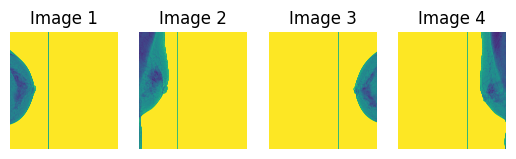

In [9]:
def load_dicom_images(directory):
    dicom_images = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            dicom_images.append(pydicom.dcmread(os.path.join(root, file)))
    return dicom_images

def visualize_dicom_images(images, num_samples):
    sample_images = images[:num_samples]
    for i, image in enumerate(sample_images):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.pixel_array)
        plt.title(f"Image {i + 1}")
        plt.axis('off')
    plt.show()
    
train_dcm_folder = "/kaggle/input/rsna-breast-cancer-detection/train_images/10006"
dcm_img=load_dicom_images(train_dcm_folder)
visualize_dicom_images(dcm_img,4)

In [10]:
# Afficher la taille de chaque ensemble
print(f"Taille de l'ensemble d'entraînement : {len(df_train)}")

Taille de l'ensemble d'entraînement : 54706


In [11]:
# the number of patients with malignant cancer
len(df_train[df_train['cancer'] == 1])

1158

In [12]:
# the number of patients without malignant cancer
len(df_train[df_train['cancer'] == 0])

53548

In [13]:
# the number of patient who took biopsy
len(df_train[df_train['biopsy'] == 1])

2969

In [14]:
# the number of patients whose malignant cancer is invasive
len(df_train[df_train['invasive'] == 1])

818

In [15]:
df_test.head()


,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [16]:
# Afficher la taille de test
print(f"Taille de l'ensemble de test : {len(df_test)}")

Taille de l'ensemble de test : 4


In [17]:
#afficher le nombre des differents patients 
#l'age minimal et l'age maximal dans la dataset

num_patients = df_train['patient_id'].nunique()
min_patient_age = df_train['age'].min()
max_patient_age = df_train['age'].max()


print(f"There are {num_patients} different patients in the train set.\n")
print(f"The youngest patient is {int(min_patient_age)} years old.")
print(f"The oldest patient is {int(max_patient_age)} years old.\n")


There are 11913 different patients in the train set.

The youngest patient is 26 years old.
The oldest patient is 89 years old.



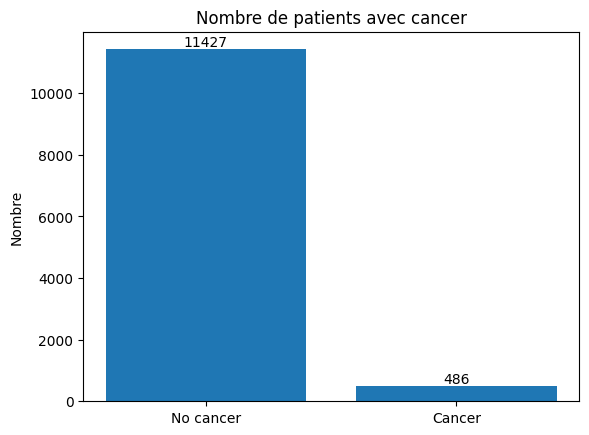

In [18]:
#"Nombre de patients atteints de cancer"
cancer_per_patient = df_train.groupby("patient_id")["cancer"].max().values
n_negative = (cancer_per_patient == 0).sum()
n_positive = (cancer_per_patient == 1).sum()

fig, ax = plt.subplots()
bars = ax.bar(["No cancer", "Cancer"], [n_negative, n_positive])
ax.set(xlabel="", ylabel="Nombre", title="Nombre de patients avec cancer")
for bar, count in zip(bars, [n_negative, n_positive]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, count, ha="center", va="bottom")
plt.show()

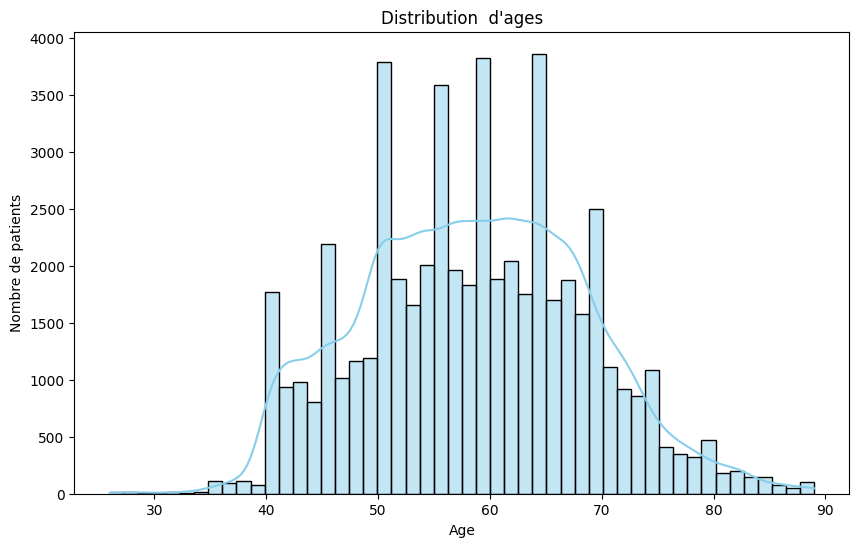

In [19]:
# Distribution d'ages
plt.figure(figsize=(10, 6))
sns.histplot(df_train.age, bins=50, kde=True, color='skyblue')
plt.title("Distribution  d'ages")
plt.xlabel('Age')
plt.ylabel('Nombre de patients')
plt.show()


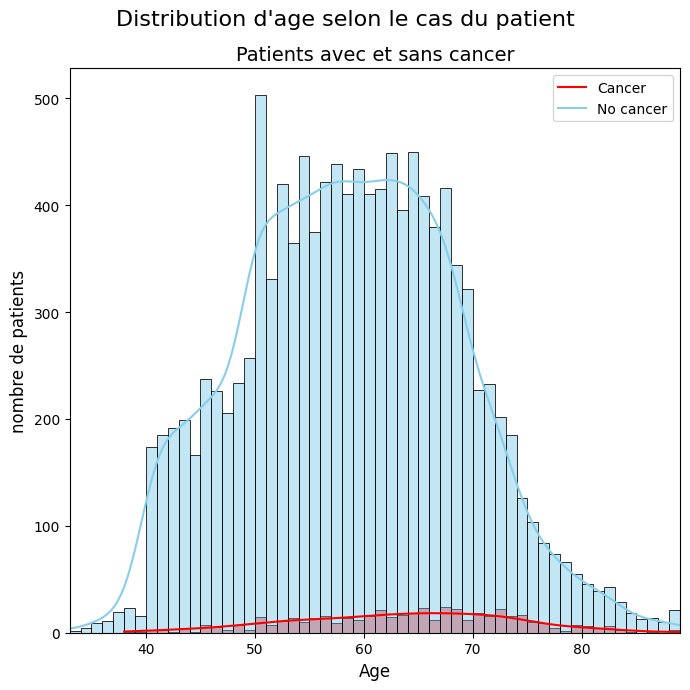

In [20]:
ages = df_train.groupby('patient_id')['age'].apply(lambda x: x.unique()[0])
cancer_ages = df_train[df_train['cancer'] == 1].groupby('patient_id')['age'].apply(lambda x: x.unique()[0])
no_cancer_ages = df_train[df_train['cancer'] == 0].groupby('patient_id')['age'].apply(lambda x: x.unique()[0])

plt.figure(figsize=(7, 7))

sns.histplot(cancer_ages, bins=51, color='red', kde=True)
sns.histplot(no_cancer_ages, bins=63, color='skyblue', kde=True)
plt.title("Patients avec et sans cancer", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("nombre de patients", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(33, 89)
plt.legend(["Cancer", "No cancer"], fontsize=10)

plt.suptitle("Distribution d'age selon le cas du patient", fontsize=16)
plt.tight_layout()
plt.show()



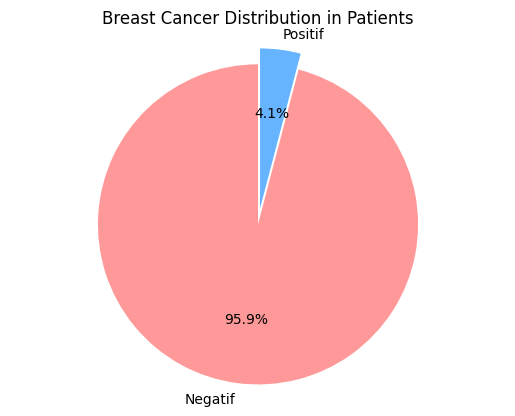

In [21]:
#Distribution du cancer des seins chez les Patients
labels = ['Negatif', 'Positif']
sizes = [n_negative / num_patients, n_positive / num_patients]
colors = ['#ff9999', '#66b3ff']  # rouge pour negatif, bleu pour positif
explode = (0.1, 0)  

# afficher le pie chart
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

ax1.axis('equal')

# Titre
plt.title('Breast Cancer Distribution in Patients')

plt.show()

<Axes: xlabel='class', ylabel='count'>

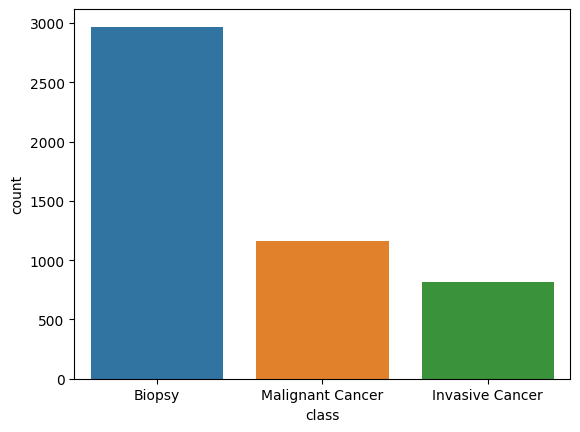

In [22]:
# jusqu'à 3000 patient a pris biopsy et malignant cancer est trouvé chez quelque uns d'eux.
data = pd.DataFrame(np.concatenate([['Biopsy'] * len(df_train[df_train['biopsy'] == 1]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [23]:
# le nombre des cas not-malignant cancer après biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)])

1811

In [24]:
# le nombre des cas malignant cancer après biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 1)])

1158

<Axes: xlabel='class', ylabel='count'>

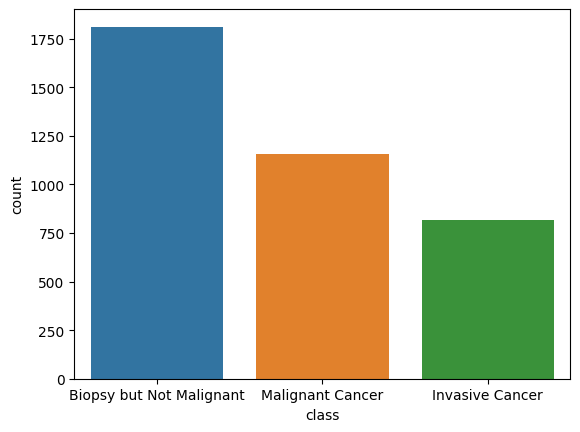

In [25]:
# 60% biopsy resulted in not-malignanct cancer.
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

Matrice de Correlation

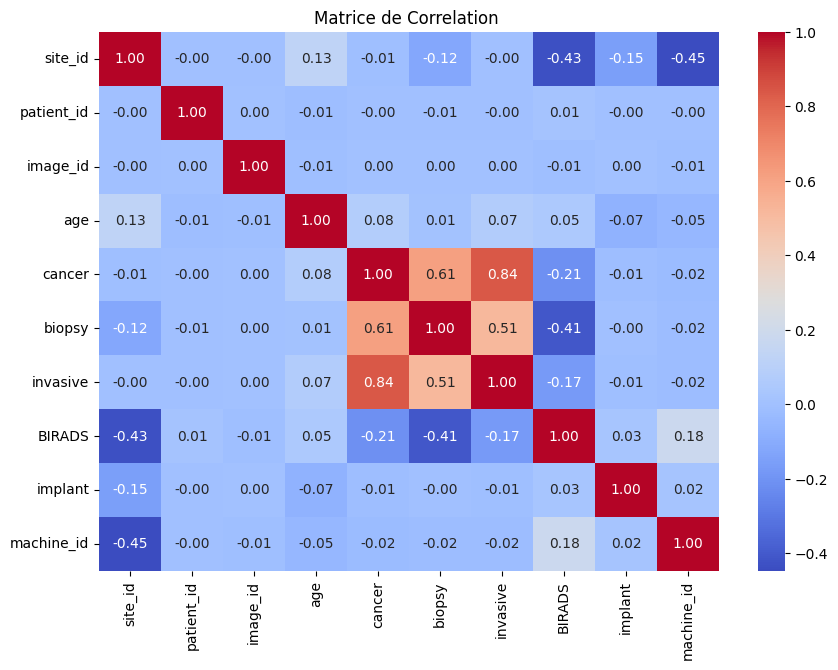

In [26]:
# affiche la matrice de correlation
numeric_columns = df_train.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(10,7))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Correlation ')
plt.show()

Pretraintement des donnees

In [27]:
# verifié les valeurs nulles et manquantes dans le DataFrame
df_train.isnull().sum()
df_train.isna().sum()


site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

In [28]:
# Selectionner uniquement les columns numeriques du DataFrame
numeric_columns = df_train.select_dtypes(include=['int64', 'float64'])

# Creer la matrice de correlation 
corr_matrix = numeric_columns.corr()

# "Classer les corrélations entre la colonne 'cancer' et les autres colonnes numériques."

cancer_correlations = corr_matrix['cancer'].sort_values(ascending=False)

print(cancer_correlations)

cancer        1.000000
invasive      0.837815
biopsy        0.613872
age           0.075155
image_id      0.000223
patient_id   -0.003253
site_id      -0.009975
implant      -0.014311
machine_id   -0.024888
BIRADS       -0.210718
Name: cancer, dtype: float64


Creer une dataset equilibrée

In [29]:
# "Le nombre de cas positifs (malignes) et négatifs (non malignes) devrait être le même 
#  pour créer un dataset équilibré."
df_train = df_train.groupby(['cancer']).apply(lambda x: x.sample(1158, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', df_train.shape[0])

New Data Size: 2316


In [30]:
RSNA_512_path = '/kaggle/input/rsna-breast-cancer-512-pngs'
#"Créer le chemin d'accès à chaque image."
for i in range(len(df_train)):
    df_train.loc[i, 'path'] = os.path.join(RSNA_512_path + '/' + str(df_train.loc[i, 'patient_id']) + '_' + str(df_train.loc[i, 'image_id']) + '.png')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,57392,1780849741,R,MLO,56.0,0,0,0,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-512-pngs/5739...
1,2,16226,1709000673,L,CC,49.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1622...
2,1,21811,1381301096,L,CC,58.0,0,0,0,1.0,0,D,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2181...
3,1,47683,2097634131,L,CC,75.0,0,0,0,1.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4768...
4,2,25277,806543610,L,CC,58.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/2527...


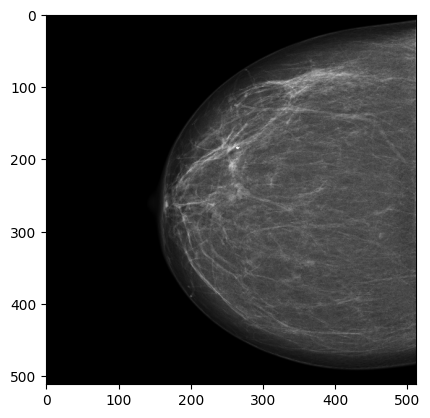

In [31]:
# exemple image
img = cv2.imread(df_train.loc[10, 'path'])
plt.imshow(img, cmap = 'gray')

In [32]:
img.shape


(512, 512, 3)

In [33]:
from sklearn.model_selection import train_test_split

Diviser les données entre Training Test et Validation

In [34]:
# Split into train and temp (combined validation and test) sets
train_df, temp_df = train_test_split(df_train, 
                                      test_size=0.4, 
                                      random_state=2018, 
                                      stratify=df_train['cancer'])

# Further split temp_df into validation and test sets
validation_df, test_df = train_test_split(temp_df, 
                                           test_size=0.5, 
                                           random_state=2018, 
                                           stratify=temp_df['cancer'])

# afficher la taille de chaque ensemble
print('train:', train_df.shape[0])
print('validation:', validation_df.shape[0])
print('test:', test_df.shape[0])
print('train', train_df['cancer'].value_counts())
print('test', test_df['cancer'].value_counts())
print('validation', validation_df['cancer'].value_counts())


train: 1389
validation: 463
test: 464
train cancer
1    695
0    694
Name: count, dtype: int64
test cancer
0    232
1    232
Name: count, dtype: int64
validation cancer
0    232
1    231
Name: count, dtype: int64


In [35]:
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
645,1,46662,1485476157,R,CC,61.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4666...
1918,1,54084,1440235181,R,MLO,75.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5408...
1197,1,36034,80000307,L,MLO,67.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3603...
1420,1,57754,690582134,L,MLO,46.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5775...
688,1,40410,1301430781,R,MLO,70.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4041...


In [36]:
len(train_df[train_df['cancer'] == 0])

694

In [37]:
len(train_df[train_df['cancer'] == 1])

695

In [38]:
len(test_df[test_df['cancer'] == 0])

232

In [39]:
len(test_df[test_df['cancer'] == 1])

232

In [40]:
len(validation_df[validation_df['cancer'] == 0])

232

In [41]:
len(validation_df[validation_df['cancer'] == 1])

231

In [42]:
# "Afficher les premières lignes de l'ensemble d'entraînement."
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
1800,1,39280,1448042992,R,MLO,74.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3928...
2259,1,25432,2058514481,R,MLO,41.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2543...
976,1,19759,525939427,R,MLO,47.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/1975...
676,2,19447,1605240712,R,MLO,62.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1944...
393,1,4079,2106823405,R,MLO,84.0,0,0,0,1.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4079...


In [43]:
# "Afficher les premières lignes de l'ensemble de test."
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
645,1,46662,1485476157,R,CC,61.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4666...
1918,1,54084,1440235181,R,MLO,75.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5408...
1197,1,36034,80000307,L,MLO,67.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3603...
1420,1,57754,690582134,L,MLO,46.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5775...
688,1,40410,1301430781,R,MLO,70.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4041...


In [44]:
# "Afficher les premières lignes de l'ensemble de validation."
validation_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
1758,1,8732,647267886,L,MLO,45.0,1,1,0,0.0,0,D,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/8732...
1967,2,65427,808462263,L,CC,60.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/6542...
1881,1,47382,2129270210,L,MLO,72.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4738...
507,1,4812,2117164190,R,MLO,47.0,0,0,0,NaN,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4812...
813,1,46174,197015901,R,MLO,78.0,0,0,0,1.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4617...


Creer un dossier pour chaque ensemble

In [45]:
import shutil

train_df_normal = train_df[train_df['cancer'] == 0].reset_index(drop = True)

# Definir le dossier destination
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/normal'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# copier les images vers le dossier destination
for path in train_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [46]:
# Definir le dossier destination
train_df_cancer = train_df[train_df['cancer'] == 1].reset_index(drop = True)

destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/cancer'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# copier les images vers le dossier destination
for path in train_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

In [47]:
test_df_normal = test_df[test_df['cancer'] == 0].reset_index(drop = True)

# copier les images vers le dossier destination
destination_dir = '/kaggle/working/test'
destination_dir_sub = '/kaggle/working/test/normal'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# copier les images vers le dossier destination
for path in test_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [48]:
test_df_cancer = test_df[test_df['cancer'] == 1].reset_index(drop = True)

# copier les images vers le dossier destination
destination_dir = '/kaggle/working/test'
destination_dir_sub = '/kaggle/working/test/cancer'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# copier les images vers le dossier destination
for path in test_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

In [49]:
val_df_normal = validation_df[validation_df['cancer'] == 0].reset_index(drop = True)

# copier les images vers le dossier destination
destination_dir = '/kaggle/working/validation'
destination_dir_sub = '/kaggle/working/validation/normal'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# copier les images vers le dossier destination
for path in val_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [50]:
val_df_cancer = validation_df[validation_df['cancer'] == 1].reset_index(drop = True)

# copier les images vers le dossier destination
destination_dir = '/kaggle/working/validation'
destination_dir_sub = '/kaggle/working/validation/cancer'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# copier les images vers le dossier destination
for path in val_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

In [51]:
import glob
normal_train_images = glob.glob('/kaggle/working/train/normal/*.png')
cancer_train_images = glob.glob('/kaggle/working/train/cancer/*.png')

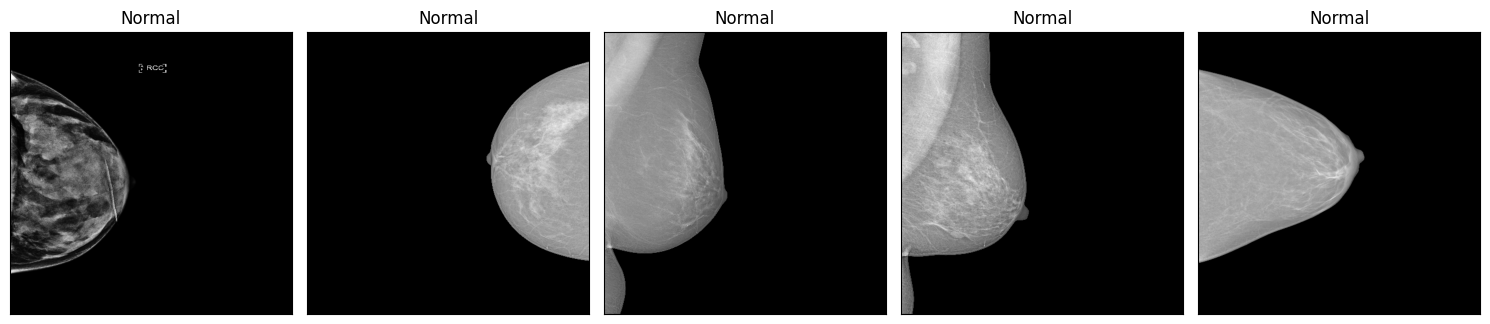

In [52]:
# afficher quelques images normal du training set
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    ax.imshow(img)
    ax.set_title('Normal')
    
fig.tight_layout()    

plt.show()

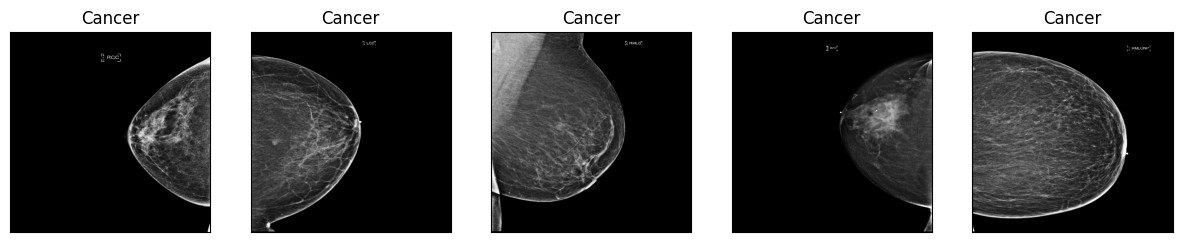

In [53]:
# afficher quelques images cancer du training set
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(cancer_train_images[i])
    ax.imshow(img)
    ax.set_title('Cancer')
    
plt.show()
    


**Create Image data Generators
******
The dataset has already been divided into train , test and validation datasets, and each dataset includes normal and cancer image files. Thus, image data generators were easily created.

In [54]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


In [55]:
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/validation'
test_path ='/kaggle/working/test'

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size = (512, 512),
        batch_size = 16,
        class_mode = 'binary'
)
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size = (512, 512),
        batch_size = 16,
        class_mode = 'binary'
)

Found 1225 images belonging to 2 classes.
Found 433 images belonging to 2 classes.
Found 436 images belonging to 2 classes.


**Define the Model (Transfer Learning)****

**Here, ResNet50V2 was employed as the base model for transfer learning. It would be also possible to conduct fine tuning with the model. The choice of hyperparameters depends on the type of task by machine learning. Sigmoid, adam, and binary cross entropy were selected for the final activation function, optimizer, and loss function, respectively.

In [56]:
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])


94668760/94668760 [==============================] - 1s 0us/step


In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23827201 (90.89 MB)
Trainable params: 262401 (1.00 MB)
Non-trainable params: 23564800 (89.89 MB)
___________

**Train the Model
**
The model was trained with the train and validation data. Early stopping was added to prevent overfitting. In fact, it might be preferable to set the larger number of epochs.

In [58]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 15, callbacks = callback)

Epoch 1/15
20/20 [==============================] - 481s 24s/step - loss: 0.8020 - accuracy: 0.5109 - val_loss: 0.6824 - val_accuracy: 0.5704
Epoch 2/15
20/20 [==============================] - 432s 22s/step - loss: 0.6739 - accuracy: 0.5932 - val_loss: 0.6773 - val_accuracy: 0.5843
Epoch 3/15
20/20 [==============================] - 465s 24s/step - loss: 0.6727 - accuracy: 0.5835 - val_loss: 0.6866 - val_accuracy: 0.5450
Epoch 4/15
20/20 [==============================] - 475s 24s/step - loss: 0.6686 - accuracy: 0.5984 - val_loss: 0.7023 - val_accuracy: 0.5358
Epoch 5/15
20/20 [==============================] - 449s 23s/step - loss: 0.6765 - accuracy: 0.5844 - val_loss: 0.6917 - val_accuracy: 0.5404
Epoch 6/15
20/20 [==============================] - 476s 24s/step - loss: 0.6671 - accuracy: 0.6094 - val_loss: 0.6698 - val_accuracy: 0.5866
Epoch 7/15
20/20 [==============================] - 442s 22s/step - loss: 0.6338 - accuracy: 0.6406 - val_loss: 0.6740 - val_accuracy: 0.5681
Epoch 

**Save the Model
******

In [59]:
model.save('mammography_pred_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Model Metrics

**The accuracy and loss were calculated for both train and validation data in the model training process.

In [60]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

****Visualizing Accuracy and Loss¶


Text(0, 0.5, 'loss')

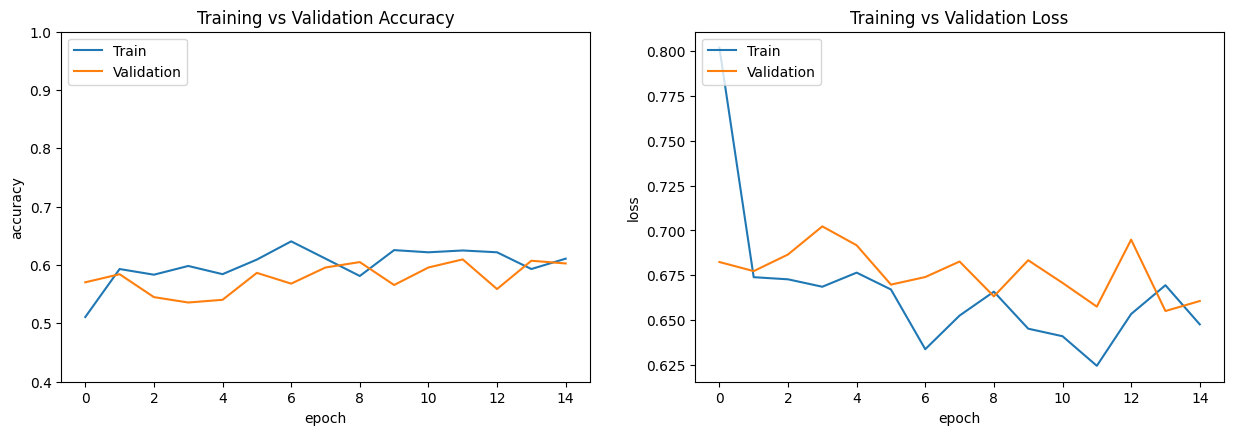

In [61]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

**Predictions**

In order to evaluate the quality of the trained model, the outcome was predicted from the test (validation) data and compared with the observed value. The threshold was set as 0.5 and the predicted value of more than 0.5 was treated as 1, which is positive.

In [62]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/mammography_pred_model.h5')

In [63]:
pred = model.predict(validation_generator)

28/28 [==============================] - 172s 6s/step


In [64]:
# prediction by the AI
pred

array([[0.5804215 ],
       [0.3671553 ],
       [0.40872392],
       [0.65927917],
       [0.45812127],
       [0.6691206 ],
       [0.44838178],
       [0.55861825],
       [0.55775154],
       [0.4708152 ],
       [0.5061242 ],
       [0.47527775],
       [0.36767945],
       [0.3901053 ],
       [0.30983546],
       [0.3542342 ],
       [0.5607521 ],
       [0.6010978 ],
       [0.46898156],
       [0.67858034],
       [0.47054935],
       [0.5546434 ],
       [0.46474165],
       [0.49903047],
       [0.57583624],
       [0.6945614 ],
       [0.39471278],
       [0.62667537],
       [0.5438948 ],
       [0.37854716],
       [0.6276048 ],
       [0.44382948],
       [0.35380393],
       [0.5766106 ],
       [0.53351825],
       [0.6354636 ],
       [0.30493078],
       [0.46908394],
       [0.32319638],
       [0.48391476],
       [0.711791  ],
       [0.46951094],
       [0.7238254 ],
       [0.2990438 ],
       [0.5169261 ],
       [0.6145054 ],
       [0.4055337 ],
       [0.430

In [65]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)


In [66]:
print(y_pred)

[1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 

In [67]:
pd.Series(y_pred).value_counts()

0    250
1    183
Name: count, dtype: int64

In [68]:
y_true = validation_generator.classes

In [69]:
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


****Confusion Matrix

Confusion matrix was created with the predicted and observed values. The matrix indicated almost correct predictions by the trained model except that there were two cases observed as false positive. False positive means that a case is actually negative but predicted as positive.

In [70]:
cm = confusion_matrix(y_true, y_pred)

Text(50.722222222222214, 0.5, 'Truth')

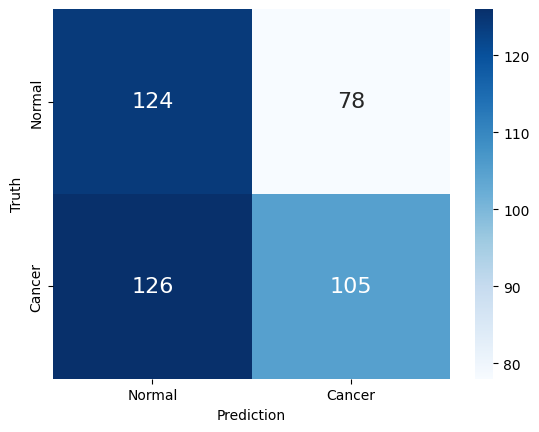

In [101]:
# Define the class names.
class_names = ['Normal', 'Cancer']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

****Classification Report

Classification report describes precision, recall, and f1-score as to each value. Many people regard accuracy and f1-score as the most important indicator to evaluate an AI model. This may be correct, but is not necessarily correct in the clinical field. It must be considered why AI can be useful for and accepted by healthcare professionals. They expect that AI may be able to reduce their workload. What does it mean to reduce their workload by AI? One idea is to exclude lots of negative cases by AI that healthcare professionals would not have to see in order that they would be able to concentrate on the remaining positive cases to be treated. Thus, it is required that the AI should be able to exclude negative cases without false negatives, which are actually positive but predicted as negative. Otherwise, they would have to re-check the negative cases in order not to miss actually positive cases. They must absolutely avoid clinical negligence! Therefore, if the AI model does not give rise to false negative cases, the model will be considerably acceptable in the healthcare field regardless of the accuracy or f1-score.

In [71]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.61      0.55       202
           1       0.57      0.45      0.51       231

    accuracy                           0.53       433
   macro avg       0.53      0.53      0.53       433
weighted avg       0.54      0.53      0.53       433



****Analysing the Results

It is crucial in the medical field to analyze what kinds of cases were misclassified by the AI model, because medical misdiagnosis must be avoided as much as possible. Thus, it is necessary to identify false positive and false negative cases. Making a data frame and confusion table can visualize the results. As discussed above, false negative cases must be particularly avoided.

In [72]:
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [73]:
print(confusion)

['FP', 'TN', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'TN', 'TN', 'TN', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'TN', 'TN', 'TN', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'TN', 'TN', 'FP', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'FP', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'TN', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'TN', 'TN', 'FP', 'TN', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'TN', 'TN', 'TN', 'TN', 'FP', 'TN', 'TN', 'TN

In [74]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table

,Results
0,FP
1,TN
2,TN
3,FP
4,TN
...,...
428,FN
429,TP
430,TP
431,TP


In [75]:
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,1,0,FP
1,0,0,TN
2,0,0,TN
3,1,0,FP
4,0,0,TN
...,...,...,...
428,0,1,FN
429,1,1,TP
430,1,1,TP
431,1,1,TP


In [76]:
confusion_table.Results == 'FP'

0       True
1      False
2      False
3       True
4      False
       ...  
428    False
429    False
430    False
431    False
432    False
Name: Results, Length: 433, dtype: bool

In [77]:
# list of false positive images
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
0,1,0,FP
3,1,0,FP
5,1,0,FP
7,1,0,FP
8,1,0,FP
...,...,...,...
186,1,0,FP
187,1,0,FP
194,1,0,FP
196,1,0,FP


In [78]:
FPs.index

Index([  0,   3,   5,   7,   8,  10,  16,  17,  19,  21,  24,  25,  27,  28,
        30,  33,  34,  35,  40,  42,  44,  45,  53,  54,  57,  58,  61,  62,
        64,  65,  66,  67,  72,  86,  96,  97,  98, 101, 102, 113, 117, 118,
       121, 125, 126, 127, 128, 130, 131, 135, 136, 137, 138, 141, 144, 147,
       148, 151, 152, 153, 154, 157, 158, 163, 168, 172, 173, 175, 177, 181,
       182, 183, 185, 186, 187, 194, 196, 201],
      dtype='int64')

In [79]:
# list of false negative images
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results
202,0,1,FN
205,0,1,FN
207,0,1,FN
213,0,1,FN
214,0,1,FN
...,...,...,...
423,0,1,FN
425,0,1,FN
426,0,1,FN
427,0,1,FN


In [80]:
FNs.index

Index([202, 205, 207, 213, 214, 216, 217, 220, 222, 225,
       ...
       415, 417, 420, 421, 422, 423, 425, 426, 427, 428],
      dtype='int64', length=126)

****Misclassficiation Cases

It is impoertant to pick up wrong cases judged by the AI and to analyze why the AI made wrong judgements for these images.

In [94]:
import glob
val_images = glob.glob('/kaggle/working/validation/*/*.png')

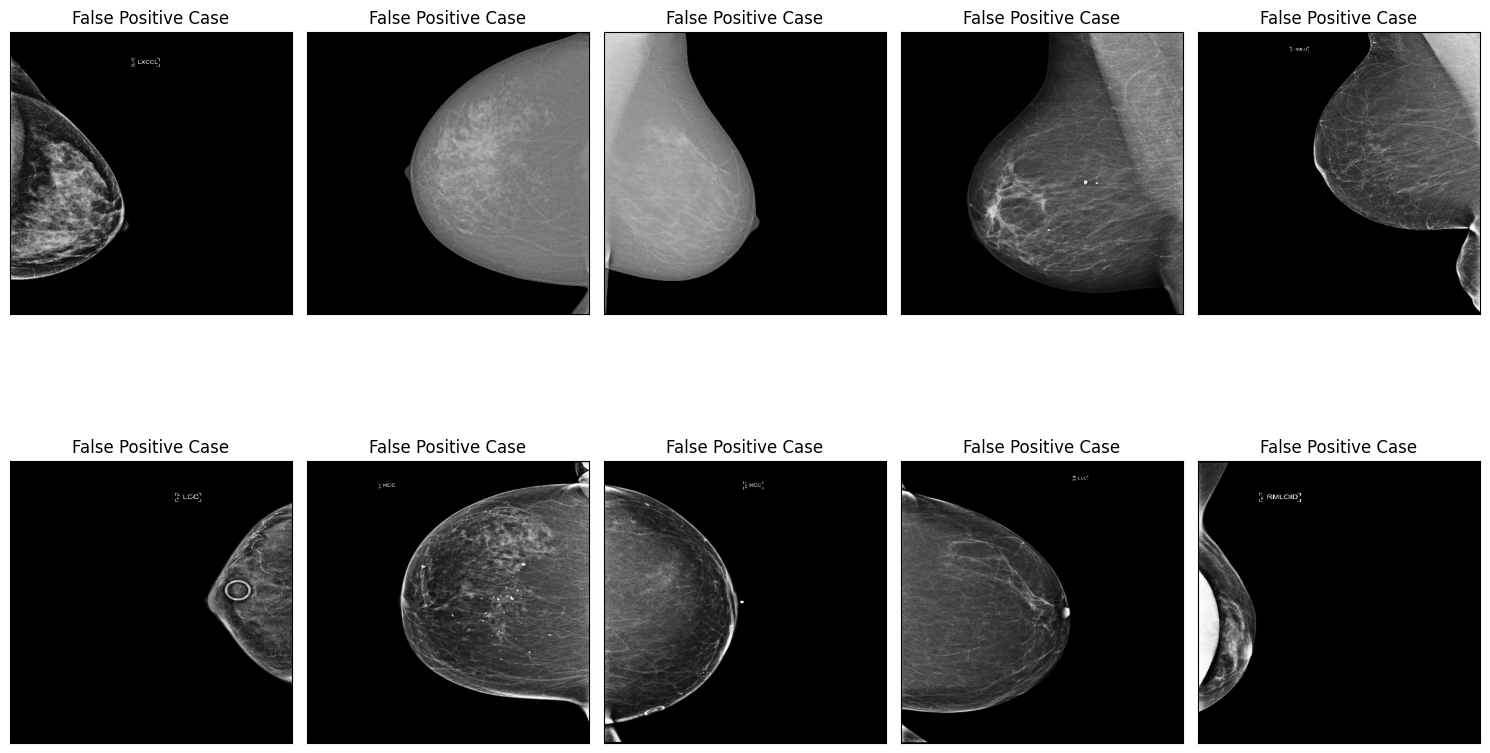

In [95]:
# False positive imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FPs.index[:min(len(FPs), 10)], axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()    

plt.show()



In [96]:
print(val_images[:5])  # Print the first 5 paths for inspection


['/kaggle/working/validation/normal/53155_86891798.png', '/kaggle/working/validation/normal/37808_279340708.png', '/kaggle/working/validation/normal/9852_1173595144.png', '/kaggle/working/validation/normal/20521_2090900062.png', '/kaggle/working/validation/normal/30753_475498085.png']


In [97]:
img = cv2.imread(val_images[0])
print(img)  # Print the loaded image data

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


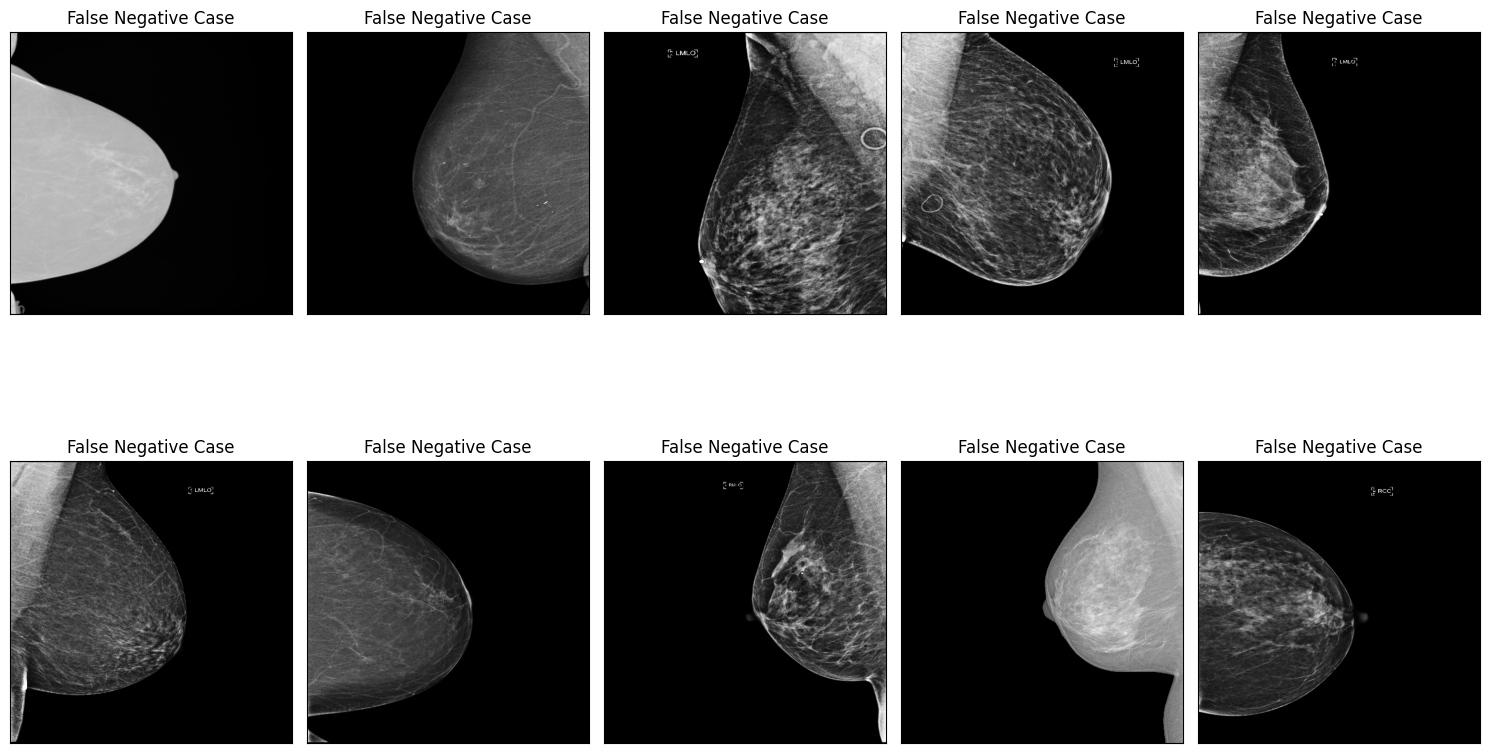

In [98]:
# False negative imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FNs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Negative Case")
fig.tight_layout()    

plt.show()

****Finetuning the Model (Unfreeying the Layers of the Model)****


In [ ]:
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = True # Change from False to True.
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

In [ ]:
model.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 50, callbacks = callback)

In [ ]:
# This time we use validation data to calculate the final accuracy.
final_accuracy = model.evaluate_generator(validation_generator)[1]

In [ ]:
final_accuracy

****Model Metrics****

In [99]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

****Visualizing Accuracy and Loss

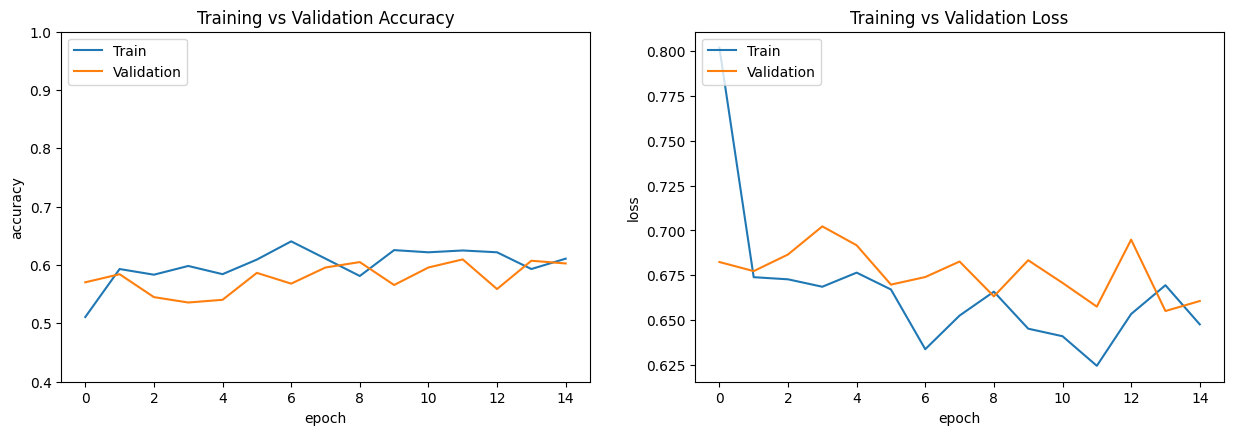

In [100]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()


****Actually, Finetuning is worse than Transfer Learning, because the number of data images is small

In [1]:
#save model
model.save('mammography_pred_model_finetuning.h5')

NameError: name 'model' is not defined

In [ ]:
# This time we use validation data to calculate the final accuracy.
final_accuracy = model.evaluate_generator(validation_generator)[1]

In [ ]:
final_accuracy